### Import Libraries

In [1]:
import warnings
def warn(*arg, **kwargs):
    pass
warnings.warn = warn

In [75]:
seed = 2018
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [76]:
from sklearn.utils import shuffle, resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset

In [78]:
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid
from torchvision import datasets, transforms

In [79]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


### Plot setup

In [9]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
%matplotlib inline

plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [10]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data preparation

In [16]:
df = shuffle(df_train_all, random_state = seed)
df_test = shuffle(df_test, random_state = seed)

In [17]:
df.shape

(1600, 9)

#### Class Balance

In [18]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [19]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [20]:
df_minor.shape[0]

559

In [21]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = seed)

In [22]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [23]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Fetaure Scaling

In [109]:
mms = StandardScaler()
train_scale = mms.fit(df.drop('label', axis=1))

xtrain = train_scale.transform(df.drop('label', axis=1))
ytrain =  np.array(df['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [110]:
np.shape(xtrain)

(1600, 8)

### Create data loader

In [111]:
class Dataset(Dataset):

    def __init__(self, data, label, transform = None):
        self.data = data
        self.labels = label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return (data, label)

    
BATCH_SIZE = 64
TEST_BATCH_SIZE = 16

# Training dataset
train_data = Dataset(xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)

# Test dataset
test_data = Dataset(xtest, ytest)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = True, num_workers = 8)

### Define hyperparameters

In [112]:
TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 2
TRAIN_EPOCHS = 100
SAMPLES = 2

In [113]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [114]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

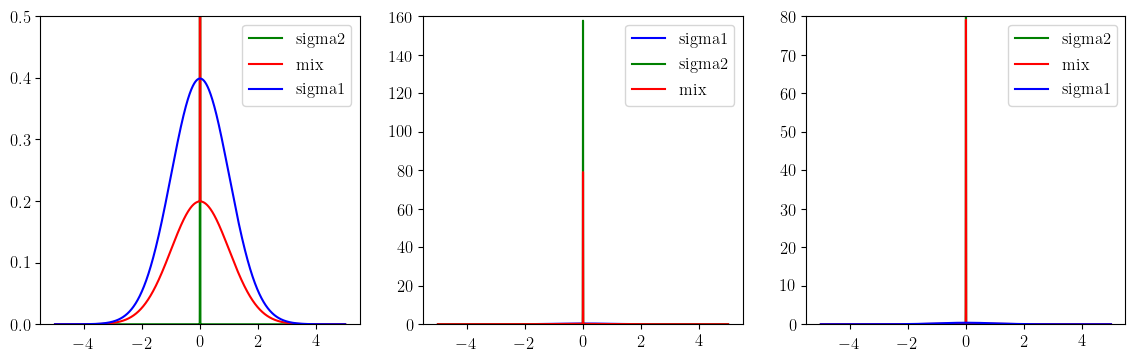

In [115]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    
    d1 = np.array([torch.exp(normal_1.log_prob(float(c))) for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(float(c))) for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(float(c))) for c in x_points])
    
    plt.subplots(1,3,figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)
    
    plt.subplot(1,3,2)
    plt.plot(x_points,d1,color="b")
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0,160)
    
    plt.subplot(1,3,3)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,80)
    
visualize_scale_mixture_components()

In [127]:
# torch.Tensor(12, 2).uniform_(-0.2, 0.2)
# torch.Tensor(8, 12).uniform_(-5,-4)

In [283]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
            
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [288]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(8, 12)
        self.l2 = BayesianLinear(12, 1)
    
    def forward(self, x, sample=False):
        x = F.relu(self.l1(x, sample))
        x = F.sigmoid(self.l2(x, sample))
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior
    
    def sample_elbo(self, data, target, samples = SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self(data, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average = False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

In [289]:
writer = SummaryWriter()
def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

In [290]:
def train(net, optimizer, epoch):
    if epoch == 0: # write initial distributions
        write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        net.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        data = data.float()
        target = Variable(target.long())
        target = target.squeeze()
        
        optimizer.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(epoch+1)

In [291]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

100%|██████████| 25/25 [00:00<00:00, 43.98it/s]


### Model Evaluation

In [175]:
TEST_SAMPLES = 5
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            
            data = data.float()
            target = Variable(target.long())
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))
    return outputs

output = test_ensemble()

Component 0 Accuracy: 326/400
Component 1 Accuracy: 323/400
Component 2 Accuracy: 329/400
Component 3 Accuracy: 329/400
Component 4 Accuracy: 330/400
Posterior Mean Accuracy: 327/400
Ensemble Accuracy: 328/400


In [360]:
def RuptureNet(x, l1_weight, l2_weight, l1_bias, l2_bias):
#     print(np.shape(x), np.shape(l1_weight), np.shape(l1_bias), np.shape(l2_weight))
    x = torch.from_numpy(x)
    l1_weight = torch.from_numpy(l1_weight)
    l2_weight = torch.from_numpy(l2_weight)
    l1_bias = torch.from_numpy(l1_bias)
    l2_bias = torch.from_numpy(l2_bias)
    
    print(x.size(), l1_weight.size(), l1_bias.size())
    l1 = F.relu(F.linear(x, l1_weight, l1_bias))
    score = F.sigmoid(F.linear(l1, l2_weight, l2_bias))
    return score

In [361]:
x = np.random.randn(400, 8)

In [362]:
l1_weight = np.random.randn(500, 8, 12)
l1_bias = np.random.randn(500, 12)
# l1 = F.relu(torch.from_numpy(np.dot(x, l1_weight) + l1_bias))
l2_weight = np.random.randn(500, 12, 1)
l2_bias = np.random.randn(500, 1)


In [363]:
aa = np.stack([RuptureNet(x, l1_weight[i], l2_weight[i], l1_bias[i], l1_bias[i]) for i in range(500)], axis=0)

torch.Size([400, 8]) torch.Size([8, 12]) torch.Size([12])


RuntimeError: The expanded size of the tensor (8) must match the existing size (12) at non-singleton dimension 1.  Target sizes: [400, 8].  Tensor sizes: [12]

In [312]:
l1.size()

torch.Size([400, 12])

In [315]:
# l1 = np.reshape(l1, (400, 500, 12, 1))

In [316]:
np.shape(l1.numpy()), l2_weight.shape

((400, 12), (12, 1))

In [317]:
np.shape(np.dot(l1, l2_weight))

(400, 1)

In [276]:
l2 = F.sigmoid(torch.from_numpy(np.dot(l1.numpy(), l2_weight) + l2_bias))

In [277]:
l2

tensor([[[8.1517e-10],
         [5.3046e-02],
         [5.0069e-03],
         ...,
         [1.6727e-05],
         [3.0132e-02],
         [2.4772e-06]],

        [[1.9723e-02],
         [1.6818e-02],
         [2.9470e-02],
         ...,
         [4.2018e-10],
         [9.5549e-01],
         [5.7607e-01]],

        [[2.3087e-02],
         [8.7120e-01],
         [3.5191e-01],
         ...,
         [5.5989e-09],
         [5.2426e-04],
         [9.9290e-01]],

        ...,

        [[3.3168e-01],
         [2.7081e-01],
         [6.5334e-06],
         ...,
         [1.9263e-02],
         [8.3582e-05],
         [1.2217e-05]],

        [[2.1143e-01],
         [3.8960e-03],
         [2.4798e-03],
         ...,
         [7.7009e-01],
         [8.2584e-03],
         [4.0247e-01]],

        [[3.2548e-01],
         [3.5325e-01],
         [1.7193e-02],
         ...,
         [1.6170e-02],
         [6.5127e-02],
         [1.4945e-02]]], dtype=torch.float64)

In [186]:
F.linear(x, l1_weight, l1_bias)

RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D

In [165]:
net.l1.weight_prior.gaussian2.sample()

tensor([0.0093])

In [163]:
torch.max(output)

tensor(-0.0565)

In [151]:
net.l1.weight.sample().std()

tensor(0.2096, grad_fn=<StdBackward0>)